In [80]:
# Set crucial parameters
layer_height = 0.16 # mm
line_width = 2.5 # mm
max_dim = 256 # mm

min_thickness = layer_height
max_thickness = layer_height * 20

In [81]:
%matplotlib ipympl

import numpy as np
import cv2
import os
import matplotlib.pyplot as plt

In [82]:
def show_img(img, cmap=None):
    plt.figure()
    plt.axis('off')
    plt.imshow(img, cmap=cmap)
    plt.show()

C:\Users\evand\OneDrive\Documents\Art\Photography\2025_06_20_GabbySF\jpg_images\DSC02664.JPG


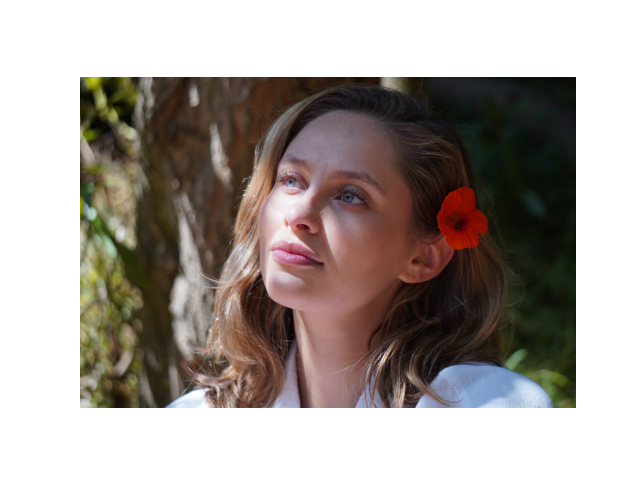

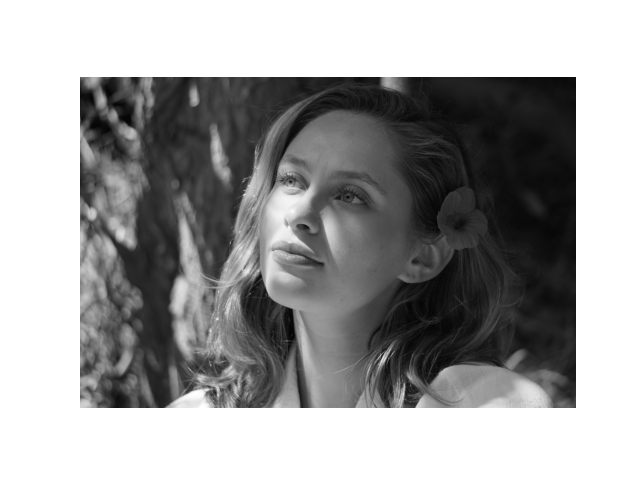

In [83]:
# Load in image with openCV
image_path = r'C:\Users\evand\OneDrive\Documents\Art\Photography\2025_06_20_GabbySF\jpg_images\DSC02696.JPG'
image_path = r'C:\Users\evand\OneDrive\Documents\Art\Photography\2025_06_20_GabbySF\jpg_images\DSC03002.JPG'
image_path = r"C:\Users\evand\OneDrive\Documents\Art\Photography\2025_06_20_GabbySF\jpg_images\DSC02664.JPG"
image_path = image_path.replace("\\\\", os.sep)

print(image_path)

img_bgr = cv2.imread(image_path)
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
img_gry = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)

show_img(img_rgb)
show_img(img_gry, cmap='gray')

Resizing image from (4000, 6000) to (68, 102)


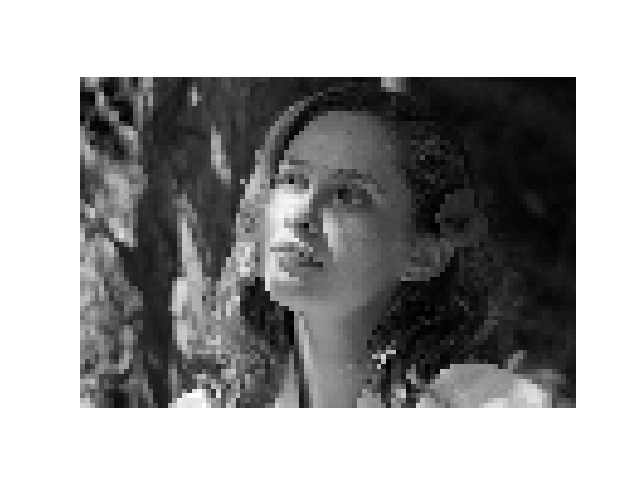

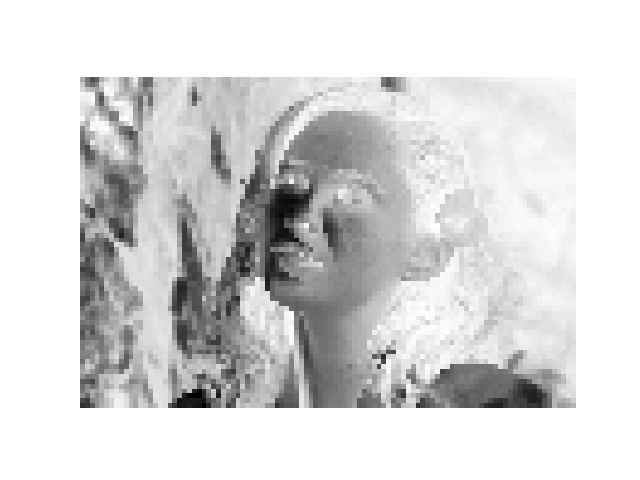

possible range: 0.16mm - 3.2mm
value range: 0.16mm - 3.1403921568627453mm


In [84]:
# Transform Image
 
ogH, ogW = img_rgb.shape[:2]

long_res = max_dim // line_width
ratio = max(ogH, ogW) / min(ogH, ogW)
short_res = long_res // ratio

H, W = (int(short_res), int(long_res)) if ogH < ogW else (int(long_res), int(short_res))

# Resize Image
print(f'Resizing image from ({ogH}, {ogW}) to ({H}, {W})')
img_rsz = cv2.resize(img_gry, (W, H), interpolation=cv2.INTER_LINEAR)
show_img(img_rsz, cmap='gray')

# Invert and re-scale image
""" No need to posterize - this will happen for free in slicer?
# Posterize Image
img_pst = np.ceil(img_rsz / (255 / n_values)).astype(np.uint8)
show_img(img_pst, cmap='gray')
"""

img_thk = min_thickness + (1.0 - img_rsz / 255.0) * (max_thickness - min_thickness)
show_img(img_thk, cmap='gray')

print(f'possible range: {min_thickness}mm - {max_thickness}mm')
print(f'value range: {np.min(img_thk)}mm - {np.max(img_thk)}mm')

### STL Format Example

https://top3dshop.com/blog/the-ultimate-guide-to-stl-format

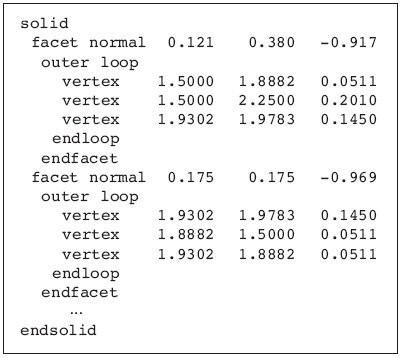

In [85]:
class STL_Tri:
    def __init__(self, v1=None, v2=None, v3=None, normal=None):
        # v1 -> v2 -> v3 must be defined in a counter-clockwise manner such that the right-handed normal vector points outward
        self.v1 = v1
        self.v2 = v2
        self.v3 = v3

        # If normal is set at instantiation, then we won't compute it from vertices
        self.normal = normal
        self.recompute_normal = normal is None

        self.__zero_area = False
        self.compute_normal()

    
    def compute_normal(self):
        if not self.recompute_normal:
            return
        
        if any(x is None for x in [self.v1, self.v2, self.v3]):
            return
        
        normal = np.cross((self.v2-self.v1),(self.v3-self.v2))
        length = np.linalg.norm(normal)

        if length == 0:
            print('Encountered zero-area tri...')
            self.__zero_area = True
            return
        
        self.normal = normal / length

    def compute_area(self):
        return 0.5 * np.linalg.norm(np.abs(np.cross(self.v2 - self.v1, self.v3 - self.v1)))
    
    def zero_area(self):
        return self.__zero_area if self.__zero_area is not None else self.compute_area() == 0.0
    


In [86]:
# Create array of 3D coordinates (in mm) to house image vertex data

X, Y = np.meshgrid(np.arange(0,W), np.arange(0,H))
X = X.ravel() * line_width
Y = Y.ravel() * line_width * (-1)
Y += (H - 1) * line_width

verts = np.zeros((H * W, 3), dtype=np.float32)

verts[:,0] = X
verts[:,1] = Y
verts[:,2] = img_thk.flatten()

In [87]:
# COMPUTE NUMBER OF TRIANGLES TO BE IN MESH
num_tri_img = 2 * (H * W - H - W + 1) # number of triangle in picture mesh
print(f'Image-area triangle count: {num_tri_img}')

# TODO: compute number of tris on each side (using fan optimization)
num_tri_sides_upper = 4 * (H + W) - 8
num_tri_sides_lower = 2 * (H + W)
num_tri_sides = num_tri_sides_upper + num_tri_sides_lower
print(f'Sides triangle count: {num_tri_sides}')

# Compute number of tris on bottom side if using border fan optimization tesselation method
# num_tri_bottom = 2 * (W + H + 1)
# Psych, instead pushing border fan optimization to sides to keep the bottom a 2-tri facet
num_tri_bottom = 2
print(f'Bottom surface triangle count: {num_tri_bottom}')

num_tri = num_tri_img + num_tri_sides + num_tri_bottom
print(f'Total Triangle count: {num_tri}')

# Preallocate Triangle list
tris_img  = [STL_Tri()] * num_tri_img
tris_base = [STL_Tri()] * (num_tri_sides + num_tri_bottom)

Image-area triangle count: 13534
Sides triangle count: 1012
Bottom surface triangle count: 2
Total Triangle count: 14548


In [88]:
### IMAGE MESH
# Assemble Image mesh as squares with triangle subcomponents:
#   v1---v2
#    | / |
#   v3---v4

v_idx = 0
t_idx = 0

while t_idx < num_tri_img:
    # When reach end of row, 
    # skip forward because there is no triangle to the right of this pixel
    if (v_idx + 1) % W == 0:
        v_idx += 1

    # Get verts comprising the 2-tri quad between pixel positions
    v1 = verts[v_idx,:]
    v2 = verts[v_idx + 1, :]
    v3 = verts[v_idx + W, :]
    v4 = verts[v_idx + W + 1, :]

    # Create 2 tris of the quad
    tris_img[t_idx] = STL_Tri(v1, v3, v2); t_idx += 1
    tris_img[t_idx] = STL_Tri(v2, v3, v4); t_idx += 1

    v_idx += 1

In [89]:
### Create the indices for the base verts, starting with the four corners of the bottom of the base
n_verts_base = 2 * (H + W)
verts_base = np.zeros((n_verts_base, 3), dtype=np.float32)

# From top view:
#   1---2
#   | / |
#   3---4
#
# Correct order (since upside-down): 1->2, 2->3

extents = [(H - 1) * line_width, (W - 1) * line_width]

# [X,Y,Z] verts
verts_base[0,:] = [0.0, extents[0], 0.0]        # v1
verts_base[1,:] = [extents[1], extents[0], 0.0] # v2
verts_base[2,:] = [0.0, 0.0, 0.0]               # v3
verts_base[3,:] = [extents[1], 0.0, 0.0]        # v4

tris_base[0] = STL_Tri(verts_base[0,:], verts_base[1,:], verts_base[2,:], normal=[ 0.0,  0.0, -1.0])
tris_base[1] = STL_Tri(verts_base[1,:], verts_base[3,:], verts_base[2,:], normal=[ 0.0,  0.0, -1.0])

In [90]:
### create verts for the sides of the base
Z = min_thickness

# Append with vertices going CW from top view around outer edge,
# starting with top left

X = np.arange(0, W) * line_width
Y = ((H - 1) - np.arange(0, H)) * line_width

# Top side
start = 4
verts_base[start:start+W,0] = X
verts_base[start:start+W,1] = Y[0]
verts_base[start:start+W,2] = Z

# R side
start += W
verts_base[start:start+H-1,0] = X[-1]
verts_base[start:start+H-1,1] = Y[1:]
verts_base[start:start+H-1,2] = Z

# Bottom side
start += H-1
verts_base[start:start+W-1,0] = X[::-1][1:]
verts_base[start:start+W-1,1] = 0.0
verts_base[start:start+W-1,2] = Z

# L side
start += W-1
verts_base[start:start+H-1,0] = 0.0
verts_base[start:start+H-1,1] = Y[::-1][1:-1]
verts_base[start:start+H-1,2] = Z

In [91]:
# Base side, upper triangulation

# When viewed from inside out, we need normals pointing out
#   v1---v2
#    | / |
#   v3---v4
# thus, for this configuration, the correct order is 1>2>3 for top and 2>4>3 for bottom

# NOTE: normals and verts_step change with each side we move along, going CW from top side

# Normal vectors for each side of the base along each wall
normals = np.array([[ 0.0,  1.0, 0.0],
                    [ 1.0,  0.0, 0.0],
                    [ 0.0, -1.0, 0.0],
                    [-1.0,  0.0, 0.0]])

# Step size (and direction) to take along image verts to align with correct verts_base entry when triangulating
verts_step = [1, W, -1, -W]

vb_idx = 4 # index into verts_base
vi_idx = 0 # index into verts (image verts)
t_idx = 2  # index into tris_base

for side in range(4):
    
    dim_size = H if side % 2 else W

    for i in range(dim_size - 1):
        
        v1 = verts[vi_idx]
        v2 = verts[vi_idx + verts_step[side]]
        v3 = verts_base[vb_idx]
        vb_idx = (vb_idx + 1) if vb_idx < (n_verts_base-1) else 4
        v4 = verts_base[vb_idx]
                
        vi_idx += verts_step[side]
        nor = normals[side,:]

        tris_base[t_idx] = STL_Tri(v1, v2, v3, normal=nor); t_idx += 1
        tris_base[t_idx] = STL_Tri(v2, v4, v3, normal=nor); t_idx += 1



In [92]:
# Final Triangulation Step: Fan method between base 4 verts and the min_thickness layer

vb_idx = 4
t_start = t_idx

for side in range(4):

    v_bottom = verts_base[side]

    dim_size = H if side % 2 else W

    for i in range(dim_size - 1):

        v1 = verts_base[vb_idx]
        vb_idx = (vb_idx + 1) if vb_idx < (n_verts_base-1) else 4
        v2 = verts_base[vb_idx]
        v3 = v_bottom

        tris_base[t_idx] = STL_Tri(v1, v2, v3)

    
    v1 = verts_base[vb_idx]
    v2 = verts_base[(side + 1) % 4]
    v3 = v_bottom

    tris_base[t_idx] = STL_Tri(v1, v2, v3); t_idx += 1

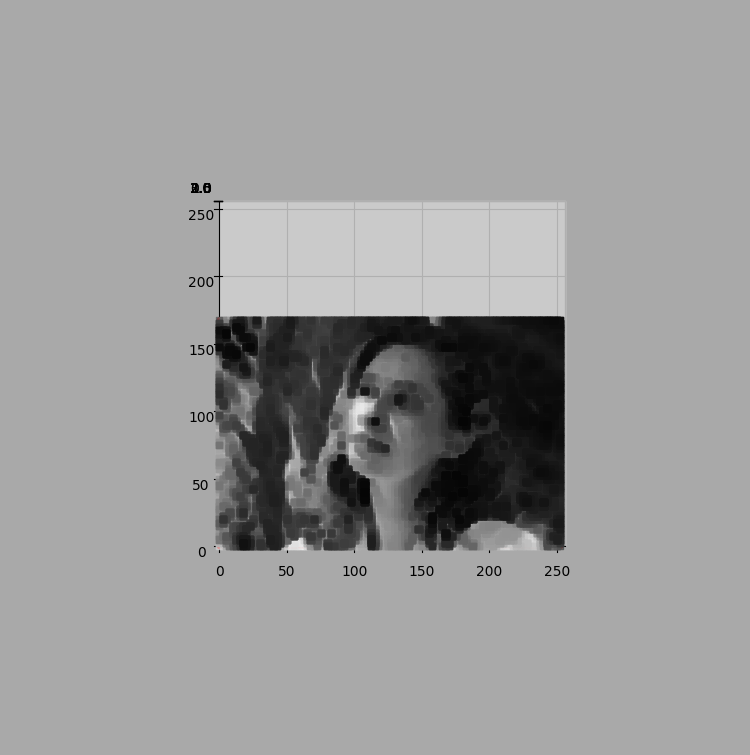

In [93]:
# Get verts from tri sides
base_verts_from_tri = np.zeros((3*len(tris_base),3))
for i, tri in enumerate(tris_base):
    base_verts_from_tri[i*3:i*3+3, :] = np.array([tri.v1, tri.v2, tri.v3])

img_verts_from_tri = np.zeros((3*len(tris_img),3))
for i, tri in enumerate(tris_img):
    img_verts_from_tri[i*3:i*3+3, :] = np.array([tri.v1, tri.v2, tri.v3]); 

colors = 1 - (img_verts_from_tri[:,2] - min_thickness) / (max_thickness - min_thickness)
colors = np.clip(colors, 0, 1)
colors = [(x,x,x) for x in colors]

# 3D scatterplot of tri verts
fig = plt.figure(facecolor='darkgrey', figsize=[7.5,7.55])
ax = fig.add_subplot(projection='3d')
ax.set_facecolor('darkgrey') 

ax.view_init(elev=90, azim=-90, roll=0)
proj_types = ['ortho','persp']
ax.set_proj_type(proj_types[0])

plt.axis('scaled')

ax.scatter(base_verts_from_tri[:,0], base_verts_from_tri[:,1], base_verts_from_tri[:,2], marker='.', c='r', s=28)
ax.scatter(img_verts_from_tri[:,0].ravel(), img_verts_from_tri[:,1].ravel(), img_verts_from_tri[:,2].ravel(), marker='s', c=colors)#colors, s=10)


ax.set_xlim(0, max_dim)
ax.set_ylim(0, max_dim)
ax.set_zlim(0, max_thickness)
plt.show()


In [94]:
# Fan portion of side walls
# TODO:
print(nor)

[-1.  0.  0.]
